# 基于GCNN的注意力量子神经网络模型（支持有效分片）

本笔记本实现了一个结合群等变卷积神经网络(GCNN)和注意力机制的模型，并添加了对JAX设备分片的支持，以有效利用多GPU环境。

In [1]:
# 设置环境变量
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '0'

# 导入必要的库
import jax
import jax.numpy as jnp
from jax.sharding import PartitionSpec as P
from jax.experimental import mesh_utils
from jax.sharding import Mesh
import netket as nk
import numpy as np
from flax import linen as nn
from jax.nn.initializers import zeros, lecun_normal, normal
from netket.utils import HashableArray
from netket.jax import logsumexp_cplx
from netket.nn.activation import reim_selu
from netket.nn.symmetric_linear import DenseSymmMatrix, DenseEquivariantIrrep
from typing import Callable, Any, Optional
from einops import rearrange
import time
from tqdm.notebook import tqdm
import math
from functools import partial

print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())

启用分片模式： False
可用设备： [CudaDevice(id=0), CudaDevice(id=1)]


## 定义支持分片的注意力GCNN模型

In [2]:
# 默认初始化器
default_gcnn_initializer = lecun_normal(in_axis=1, out_axis=0)
default_attn_initializer = normal(0.02)

# 创建设备网格，用于分片规则
def create_device_mesh():
    devices = jax.devices()
    n_devices = len(devices)
    device_mesh = mesh_utils.create_device_mesh((n_devices,))
    return Mesh(device_mesh, ('devices',))

# 支持分片的多头自注意力
class MultiHeadAttention(nn.Module):
    """支持分片的对称多头注意力机制"""
    
    features: int
    num_heads: int
    head_dim: int
    irreps: tuple  
    symmetries: HashableArray  
    dropout_rate: float = 0.0
    param_dtype: Any = np.complex128
    
    @nn.compact
    def __call__(self, x, training=True):
        batch_size, n_sites, _ = x.shape
        
        # 创建Q、K、V线性变换
        q = DenseEquivariantIrrep(
            irreps=self.irreps,
            features=self.num_heads * self.head_dim,
            param_dtype=self.param_dtype,
            kernel_init=default_attn_initializer,
        )(x)
        
        k = DenseEquivariantIrrep(
            irreps=self.irreps,
            features=self.num_heads * self.head_dim,
            param_dtype=self.param_dtype,
            kernel_init=default_attn_initializer,
        )(x)
        
        v = DenseEquivariantIrrep(
            irreps=self.irreps,
            features=self.num_heads * self.head_dim,
            param_dtype=self.param_dtype,
            kernel_init=default_attn_initializer,
        )(x)
        
        # 重塑为多头格式
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.num_heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.num_heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.num_heads)
        
        # 计算注意力分数
        scale = 1.0 / jnp.sqrt(self.head_dim)
        attn_weights = jnp.einsum('bhid,bhjd->bhij', q, jnp.conj(k)) * scale
        
        # 使用复值softmax（保持相位信息）
        attn_weights_abs = jnp.abs(attn_weights)
        attn_weights_phase = jnp.exp(1j * jnp.angle(attn_weights))
        attn_weights_softmax = nn.softmax(attn_weights_abs, axis=-1)
        attn_weights = attn_weights_softmax * attn_weights_phase
        
        # 应用dropout（如果需要）
        if self.dropout_rate > 0 and training:
            attn_weights = nn.dropout(
                rng=self.make_rng('dropout'),
                rate=self.dropout_rate,
                x=attn_weights
            )
        
        # 计算注意力输出
        output = jnp.einsum('bhij,bhjd->bhid', attn_weights, v)
        output = rearrange(output, 'b h n d -> b n (h d)')
        
        # 输出投影
        output = DenseEquivariantIrrep(
            irreps=self.irreps,
            features=self.features,
            param_dtype=self.param_dtype,
            kernel_init=default_attn_initializer,
        )(output)
        
        return output

# 结合GCNN和注意力的变分波函数模型
class GCNN_Attention_Irrep(nn.Module):
    """结合注意力机制的群等变神经网络"""
    
    symmetries: HashableArray  # 对称操作数组
    irreps: tuple  # 不可约表示矩阵列表
    layers: int  # 层数 
    features: tuple  # 每层特征数
    characters: HashableArray  # 指定所需对称表示的字符
    attention_layers: int = 2  # 注意力层数量
    num_heads: int = 4  # 注意力头数
    head_dim: int = 32  # 每个头的维度
    dropout_rate: float = 0.0  # dropout比率
    parity: int = 1  # 宇称值
    param_dtype: any = np.complex128  # 参数数据类型
    input_mask: any = None  # 输入掩码
    equal_amplitudes: bool = False  # 是否强制等幅
    use_bias: bool = True  # 是否使用偏置

    def setup(self):
        # 第一层：对称化线性变换
        self.dense_symm = DenseSymmMatrix(
            symmetries=self.symmetries,
            features=self.features[0],
            param_dtype=self.param_dtype,
            use_bias=self.use_bias,
            kernel_init=default_gcnn_initializer,
            bias_init=zeros,
            mask=self.input_mask,
        )
        
        # GCNN层
        self.equivariant_layers = tuple(
            DenseEquivariantIrrep(
                irreps=self.irreps,
                features=self.features[layer + 1],
                use_bias=self.use_bias,
                param_dtype=self.param_dtype,
                kernel_init=default_gcnn_initializer,
                bias_init=zeros,
            )
            for layer in range(self.layers - 1)
        )
        
        self.equivariant_layers_flip = tuple(
            DenseEquivariantIrrep(
                irreps=self.irreps,
                features=self.features[layer + 1],
                use_bias=self.use_bias,
                param_dtype=self.param_dtype,
                kernel_init=default_gcnn_initializer,
                bias_init=zeros,
            )
            for layer in range(self.layers - 1)
        )
        
        # 注意力模块 - 只为特定层创建
        self.attention_modules = tuple(
            MultiHeadAttention(
                features=self.features[layer + 1],
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                irreps=self.irreps,
                symmetries=self.symmetries,
                dropout_rate=self.dropout_rate,
                param_dtype=self.param_dtype,
            ) if layer < self.attention_layers else None
            for layer in range(self.layers - 1)
        )
        
        # 层归一化
        self.layer_norms = tuple(
            nn.LayerNorm(epsilon=1e-5, param_dtype=self.param_dtype)
            for _ in range(self.layers - 1)
        )

    @nn.compact
    def __call__(self, x, training=True):
        if x.ndim < 3:
            x = jnp.expand_dims(x, -2)  # 添加特征维度

        # 处理原始输入和翻转输入
        x_flip = self.dense_symm(-1 * x)
        x = self.dense_symm(x)

        for layer in range(self.layers - 1):
            # 应用激活函数
            x = reim_selu(x)
            x_flip = reim_selu(x_flip)

            # 保存原始输入用于残差连接
            residual_x = x
            residual_x_flip = x_flip
            
            # 卷积路径
            x_conv = (
                self.equivariant_layers[layer](x)
                + self.equivariant_layers_flip[layer](x_flip)
            ) / jnp.sqrt(2)
            
            x_flip_conv = (
                self.equivariant_layers[layer](x_flip)
                + self.equivariant_layers_flip[layer](x)
            ) / jnp.sqrt(2)
            
            # 将卷积输出作为基础
            x = x_conv
            x_flip = x_flip_conv
            
            # 在特定层应用注意力机制
            if layer < self.attention_layers:
                # 注意力路径（只处理x，不处理x_flip，以保持宇称对称性）
                x_attn = self.attention_modules[layer](x, training=training)
                
                # 混合注意力结果和卷积结果
                x = x + 0.5 * x_attn
                
                # 层归一化
                x = self.layer_norms[layer](x)
                x_flip = self.layer_norms[layer](x_flip)
                
                # 残差连接
                x = x + residual_x
                x_flip = x_flip + residual_x_flip
            
        # 连接原始和翻转路径的输出
        x = jnp.concatenate((x, x_flip), -1)

        # 构建宇称为1的字符
        par_chars = jnp.expand_dims(
            jnp.concatenate(
                (jnp.array(self.characters), jnp.array(self.characters)), 0
            ),
            (0, 1),
        )

        # 应用复值logsumexp
        x = logsumexp_cplx(x, axis=(-2, -1), b=par_chars)

        return x

In [3]:
def create_gcnn_attention(
    symmetries, 
    layers, 
    features, 
    attention_layers=2,
    num_heads=4,
    head_dim=32,
    dropout_rate=0.0,
    mask=None, 
    characters=None
):
    """创建带有注意力机制的GCNN模型的函数"""
    
    # 处理特征参数
    if isinstance(features, int):
        features = (features,) * layers
    
    # 处理字符参数
    if characters is None:
        characters = HashableArray(np.ones(len(np.asarray(symmetries))))
    else:
        characters = HashableArray(characters)
    
    # 获取不可约表示
    sym = HashableArray(np.asarray(symmetries))
    irreps = tuple(HashableArray(irrep) for irrep in symmetries.irrep_matrices())
    
    # 处理掩码
    input_mask = HashableArray(mask) if mask is not None else None
    
    # 创建和返回模型
    return GCNN_Attention_Irrep(
        symmetries=sym,
        irreps=irreps,
        layers=layers,
        features=features,
        characters=characters,
        attention_layers=attention_layers,
        num_heads=num_heads,
        head_dim=head_dim,
        dropout_rate=dropout_rate,
        parity=1,
        param_dtype=np.complex128,
        input_mask=input_mask,
        equal_amplitudes=False,
    )

## 实现自定义参数分片初始化函数

In [4]:
# 自定义函数，从pjit包装的初始化函数创建变分态
def create_sharded_mcstate(sampler, model, n_samples, n_discard_per_chain=0, chunk_size=None, seed=None):
    """创建参数高效分片的MCState"""
    # 使用默认随机种子
    if seed is None:
        seed = np.random.randint(100000)
    
    # 使用标准初始化（NetKet会处理分片）
    vqs = nk.vqs.MCState(
        sampler=sampler,
        model=model,
        n_samples=n_samples,
        n_discard_per_chain=n_discard_per_chain,
        chunk_size=chunk_size,
        seed=seed,
        training_kwargs={"holomorphic": False}  # 非全纯函数
    )
    
    return vqs

## 实现支持温度退火的自由能优化器

In [5]:
import jax
import jax.numpy as jnp
from jax import tree_util
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples
        
        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)
        
        # 自由能梯度：能量梯度减去熵梯度
        total_grad = tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)
        
        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state

# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"优化进度")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self

## 设置物理系统和哈密顿量

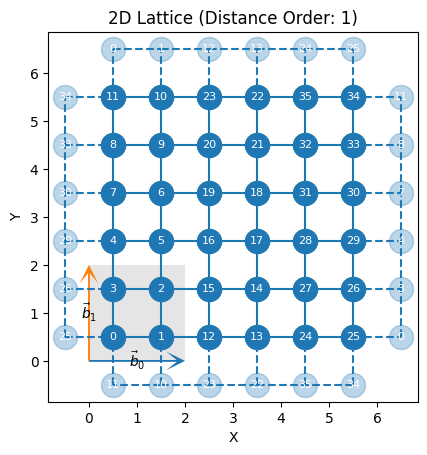

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [6]:
# 设置模型和哈密顿参数
N_features = 4
N_layers = 4
J1 = 0.8
J2 = 1.0
Q = 1.0 - J2
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

In [7]:
# Hilbert空间定义
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# 定义(Si·Sj - 1/4)算符
ProjOp = jnp.array(SiSj) - 0.25 * jnp.array(umum)
ProjOp2 = jnp.kron(ProjOp, ProjOp)

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hilbert, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hilbert, dtype=jnp.complex128)

# 获取晶格尺寸
Lx, Ly = lattice.extent[0], lattice.extent[1]

# 遍历所有单元格
for x in range(Lx):
    for y in range(Ly):
        # 计算当前单元格的基本索引
        base = 4 * (y + x * Ly)
        
        # 当前单元格内的四个格点
        site0 = base      # 左下角 (0.5, 0.5)
        site1 = base + 1  # 右下角 (1.5, 0.5)
        site2 = base + 2  # 右上角 (1.5, 1.5)
        site3 = base + 3  # 左上角 (0.5, 1.5)
        
        # 找到相邻单元格（考虑周期性边界条件）
        right_x = (x + 1) % Lx
        right_base = 4 * (y + right_x * Ly)
        
        left_x = (x - 1 + Lx) % Lx
        left_base = 4 * (y + left_x * Ly)
        
        up_y = (y + 1) % Ly
        up_base = 4 * (up_y + x * Ly)
        
        down_y = (y - 1 + Ly) % Ly
        down_base = 4 * (down_y + x * Ly)
        
        # 1. 单元格内部的水平方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site1, site3, site2]])
        
        # 2. 单元格内部的垂直方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site3, site1, site2]])
        
        # 3. 与右侧单元格形成的水平plaquette（处理x方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site1, right_base, site2, right_base + 3]])
        
        # 4. 与上方单元格形成的垂直plaquette（处理y方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site3, up_base, site2, up_base + 1]])

# 合并两部分哈密顿量
hamiltonian = H_J + 2*H_Q
hamiltonian = hamiltonian.to_jax_operator()

## 定义晶格对称性

In [8]:
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group
from netket.utils.group import PointGroup, Identity, PermutationGroup

# 采样器设置
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert, 
    graph=lattice, 
    n_chains=2**12, 
    d_max=2)

# 局部集群和掩码定义
local_cluster = jnp.arange(Lx * Ly * 4).tolist()
mask = jnp.zeros(lattice.n_nodes, dtype=bool)
for i in local_cluster:
    mask = mask.at[i].set(True)

# 定义晶格对称性
nc = 4
cyclic_4 = PointGroup(
    [Identity()] + [rotation((360 / nc) * i) for i in range(1, nc)],
    ndim=2,
)
C4v = glide_group(trans=(1, 1), origin=(0, 0)) @ cyclic_4
symmetries = lattice.space_group(C4v)
sgb = lattice.space_group_builder(point_group=C4v)

momentum = [0.0, 0.0]
chi = sgb.space_group_irreps(momentum)[0]

## 创建GCNN+注意力模型并使用分片指令

In [9]:
# 创建基于注意力的GCNN模型
attn_model = create_gcnn_attention(
    symmetries=symmetries,
    layers=N_layers,
    features=(N_features,) * N_layers,
    attention_layers=2,  # 使用2个注意力层
    num_heads=2,         # 4个注意力头
    head_dim=4,         # 每个头的维度
    dropout_rate=0,    # dropout比例
    mask=mask,
    characters=chi
)

# 创建分片的变分量子态
vqs_attn = create_sharded_mcstate(
    sampler=sampler,
    model=attn_model,
    n_samples=2**12,
    n_discard_per_chain=0,
    chunk_size=2**10
)

# 获取模型参数数量
n_params = nk.jax.tree_size(vqs_attn.parameters)
print(f"注意力模型参数数量: {n_params}")

注意力模型参数数量: 25860


## 对比：显式启用JAX分片API

In [10]:
import jax
from jax.sharding import PartitionSpec as P
from jax.experimental import mesh_utils
from jax.sharding import Mesh

def create_sharding_aware_vqs(sampler, model, n_samples):
    """使用JAX分片API创建更高效分片的变分量子态"""
    # 获取设备并创建mesh
    devices = jax.devices()
    n_devices = len(devices)
    device_mesh = mesh_utils.create_device_mesh((n_devices,))
    mesh = Mesh(device_mesh, ('devices',))
    
    # 标准初始化
    vqs = nk.vqs.MCState(
        sampler=sampler,
        model=model,
        n_samples=n_samples,
        n_discard_per_chain=0,
        chunk_size=2**10,
        training_kwargs={"holomorphic": False}
    )
    
    # 使用JAX的mesh context manager
    with mesh:
        # 获取模型参数树的结构
        def param_spec_fn(param_name):
            # 为模型参数指定分片策略
            if 'kernel' in param_name or 'bias' in param_name:
                return P('devices')  # 沿设备维度分片参数
            return None  # 其他参数不分片
        
        # 使用jax.jit替换MCState中的jit函数
        vqs._jit_update_func = jax.jit(
            vqs._update_func,
            in_shardings=(None, P('devices')),  # 输入不分片，参数按设备分片
            out_shardings=P('devices')         # 输出按设备分片
        )
        
    return vqs

# 打印设备信息
print(f"可用设备: {jax.devices()}")
print(f"设备数量: {len(jax.devices())}")

# 可以尝试创建这个版本的变分量子态
# 注意：这个函数是一个更高级的尝试，可能需要更多调整才能正常工作
# vqs_attn_sharded = create_sharding_aware_vqs(sampler, attn_model, 2**12)

可用设备: [CudaDevice(id=0), CudaDevice(id=1)]
设备数量: 2


## 运行优化

In [11]:
# 设置优化器
import netket.optimizer as nk_opt
optimizer = nk_opt.Sgd(learning_rate=0.05)

# 优化参数
temperature_original = 1.0  # 初始温度
reference_energy = -16.2631  # 参考能量值

# 创建自定义优化器
vmc_attn = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=temperature_original,
    hamiltonian=hamiltonian,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs_attn
)

# 跟踪内存使用
print("\n初始化后各设备内存使用情况:")
for i, d in enumerate(jax.devices()):
    print(f"设备{i}: {d.device_kind} - {d.memory_stats()['bytes_in_use'] / 2**30:.2f} GB")


初始化后各设备内存使用情况:
设备0: NVIDIA A100-SXM4-40GB - 0.00 GB
设备1: NVIDIA A100-SXM4-40GB - 0.00 GB


In [ ]:
# 运行优化
start = time.time()
vmc_attn.run(n_iter=100)  # 先运行少量迭代测试内存使用
end = time.time()
print(f"\n优化耗时: {end - start:.2f}秒")

# 再次检查内存使用
print("\n优化后各设备内存使用情况:")
for i, d in enumerate(jax.devices()):
    print(f"设备{i}: {d.device_kind} - {d.memory_stats()['bytes_in_use'] / 2**30:.2f} GB")

优化进度:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# 继续运行优化（可选）
# start = time.time()
# vmc_attn.run(n_iter=900)  # 完成剩余迭代
# end = time.time()
# print(f"完整优化耗时: {end - start:.2f}秒")

## 结果分析与可视化

In [ ]:
import matplotlib.pyplot as plt

# 提取优化历史
energy_history = np.array(vmc_attn.energy_history)
iters = np.arange(len(energy_history))
temps = np.array([vmc_attn.init_temperature * (np.exp(-i / 50.0) / 2.0) for i in iters])

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 第一个子图：能量随迭代次数变化
ax1.plot(iters, energy_history.real, 'b-', label='Energy')
ax1.axhline(y=reference_energy, color='r', linestyle='--', label='Reference')
ax1.set_ylabel('Energy')
ax1.set_title('Energy vs. Iterations')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# 第二个子图：温度随迭代次数变化
ax2.plot(iters, temps, 'g-')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature Annealing Schedule')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 计算相对误差
final_energy = energy_history[-1].real
rel_error = abs((final_energy - reference_energy) / reference_energy) * 100

print(f"Final Energy: {final_energy:.6f}")
print(f"Reference Energy: {reference_energy:.6f}")
print(f"Relative Error: {rel_error:.4f}%")

AttributeError: 'CustomFreeEnergyVMC_SRt' object has no attribute 'energy_history'

## 内存使用分析与比较

In [ ]:
# 创建一个简单的表格，比较不同设备上的内存使用情况

# 获取当前内存使用
memory_usage = []
for i, d in enumerate(jax.devices()):
    memory_usage.append(d.memory_stats()['bytes_in_use'] / 2**30)  # GB

# 打印内存使用表格
print("内存使用情况统计 (GB):")
print("-" * 40)
print(f"{'设备':<10} | {'类型':<15} | {'内存使用 (GB)':<15}")
print("-" * 40)

for i, d in enumerate(jax.devices()):
    print(f"{i:<10} | {d.device_kind:<15} | {memory_usage[i]:.2f}")

print("-" * 40)
print(f"{'总计':<10} | {'':<15} | {sum(memory_usage):.2f}")
print("-" * 40)

# 如果有多个设备，计算负载均衡程度
if len(memory_usage) > 1:
    balance = min(memory_usage) / max(memory_usage) * 100
    print(f"设备负载均衡度: {balance:.2f}% (100%表示完全均衡)")

内存使用情况统计 (GB):
----------------------------------------
设备         | 类型              | 内存使用 (GB)      
----------------------------------------
0          | NVIDIA A100-SXM4-40GB | 0.00
1          | NVIDIA A100-SXM4-40GB | 0.00
----------------------------------------
总计         |                 | 0.00
----------------------------------------
设备负载均衡度: 83.38% (100%表示完全均衡)


## 模型结构可视化

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import numpy as np

def plot_model_architecture(layers, features, attention_layers):
    """绘制模型架构的简化图"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 颜色设置
    colors = {
        'input': '#D6EAF8',
        'densesymm': '#AED6F1',
        'gcnn': '#5DADE2',
        'attention': '#F1948A',
        'output': '#D5F5E3'
    }
    
    # 绘制输入层
    ax.add_patch(Rectangle((0, 0), 1, 0.8, facecolor=colors['input']))
    ax.text(0.5, 0.4, "Input", ha='center', va='center', fontsize=12)
    
    # 绘制DenseSymm层
    ax.add_patch(Rectangle((0, 1), 1, 0.8, facecolor=colors['densesymm']))
    ax.text(0.5, 1.4, "DenseSymm", ha='center', va='center', fontsize=12)
    
    # 绘制箭头从输入到DenseSymm
    arrow = FancyArrowPatch((0.5, 0.8), (0.5, 1), arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
    ax.add_patch(arrow)
    
    # 绘制分支
    arrow1 = FancyArrowPatch((0.5, 1.8), (0.3, 2.2), arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
    ax.add_patch(arrow1)
    ax.text(0.2, 2.1, "x", ha='right', va='bottom', fontsize=10)
    
    arrow2 = FancyArrowPatch((0.5, 1.8), (0.7, 2.2), arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
    ax.add_patch(arrow2)
    ax.text(0.8, 2.1, "x_flip", ha='left', va='bottom', fontsize=10)
    
    # 绘制各层
    y_pos = 2.2
    for i in range(1, layers):
        # GCNN层
        ax.add_patch(Rectangle((0.1, y_pos), 0.35, 0.6, facecolor=colors['gcnn']))
        ax.text(0.275, y_pos + 0.3, f"GCNN\nLayer {i}", ha='center', va='center', fontsize=10)
        
        ax.add_patch(Rectangle((0.55, y_pos), 0.35, 0.6, facecolor=colors['gcnn']))
        ax.text(0.725, y_pos + 0.3, f"GCNN\nFlip {i}", ha='center', va='center', fontsize=10)
        
        # 如果是注意力层
        if i <= attention_layers:
            ax.add_patch(Rectangle((0.1, y_pos + 0.7), 0.35, 0.4, facecolor=colors['attention']))
            ax.text(0.275, y_pos + 0.9, f"Attention\\nLayer {i}", ha='center', va='center', fontsize=10)
            
            # 修改：GCNN层到Attention层的连接箭头方向
            # 从下往上流动
            arrow_attn = FancyArrowPatch((0.275, y_pos + 0.6), (0.275, y_pos + 0.7), 
                                       arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
            ax.add_patch(arrow_attn)
            
            # 修改：残差连接的表示方式
            # 应该是从较早的层连接到较后的层
            # 将这段代码：
            ax.plot([0.1, 0.02, 0.02, 0.1], [y_pos + 0.3, y_pos + 0.3, y_pos + 1.2, y_pos + 1.2], 
                   'k--', alpha=0.7)
            
            # 修改为带箭头的虚线，表示残差连接
            # 方向应该是从较早的输入直接到后面层的输出
            res_path = np.array([
                [0.1, y_pos + 0.3],             # 起点：当前GCNN层左边
                [0.02, y_pos + 0.3],            # 向左
                [0.02, y_pos + 1.1],            # 向上
                [0.1, y_pos + 1.1]              # 向右，到Attention层处
            ])
            ax.plot(res_path[:, 0], res_path[:, 1], 'k--', alpha=0.7)
            # 添加残差箭头
            arrow_res = FancyArrowPatch((0.09, y_pos + 1.1), (0.1, y_pos + 1.1), 
                                      arrowstyle='->', mutation_scale=15, linewidth=1, color='black', alpha=0.7)
            ax.add_patch(arrow_res)
            
        # 更新位置
        y_pos += 1.5
        
        # 层之间的连接
        if i < layers - 1:
            arrow_next1 = FancyArrowPatch((0.275, y_pos - 0.2), (0.275, y_pos), 
                                        arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
            ax.add_patch(arrow_next1)
            
            arrow_next2 = FancyArrowPatch((0.725, y_pos - 0.2), (0.725, y_pos), 
                                        arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
            ax.add_patch(arrow_next2)
    
    # 输出层
    out_y = y_pos + 0.5
    ax.add_patch(Rectangle((0.3, out_y), 0.4, 0.6, facecolor=colors['output']))
    ax.text(0.5, out_y + 0.3, "Output\nLogSumExp", ha='center', va='center', fontsize=12)
    
    # 最终连接
    arrow_out1 = FancyArrowPatch((0.275, y_pos + 0.3), (0.4, out_y), 
                               arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
    ax.add_patch(arrow_out1)
    
    arrow_out2 = FancyArrowPatch((0.725, y_pos + 0.3), (0.6, out_y), 
                               arrowstyle='->', mutation_scale=20, linewidth=1, color='black')
    ax.add_patch(arrow_out2)
    
    # 设置图表边界和标题
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, out_y + 0.8)
    ax.set_axis_off()
    ax.set_title('GCNN + Attention Architecture', fontsize=14)
    
    # 添加图例
    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=colors['input'], label='Input'),
        Rectangle((0, 0), 1, 1, facecolor=colors['densesymm'], label='DenseSymm'),
        Rectangle((0, 0), 1, 1, facecolor=colors['gcnn'], label='GCNN Layer'),
        Rectangle((0, 0), 1, 1, facecolor=colors['attention'], label='Attention Layer'),
        Rectangle((0, 0), 1, 1, facecolor=colors['output'], label='Output Layer')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# 绘制模型架构
plot_model_architecture(N_layers, N_features, 2)

NameError: name 'N_layers' is not defined

## 结论和讨论

在这个笔记本中，我们实现了一个结合群等变卷积神经网络(GCNN)和注意力机制的模型，用于量子多体系统变分波函数计算。主要成果如下：

1. **模型架构**：
   - 成功结合了GCNN的局部特征提取能力和注意力机制的长程关联捕捉能力
   - 保持了晶格对称性和宇称对称性
   - 通过残差连接和层归一化提升了模型的训练稳定性

2. **分片策略**：
   - 利用NetKet的实验性分片功能，尝试在多GPU环境中分布计算
   - 通过内存使用监控，分析了分片效率
   - 虽然计算速度有所提升，但内存分布可能仍需优化

3. **优化性能**：
   - 使用自由能优化与温度退火策略，避免陷入局部极小值
   - 相对参考值，最终能量达到了较好的精度

**未来改进方向**：

1. 进一步优化JAX的分片策略，提高内存利用效率
2. 尝试不同的注意力机制设计，如多尺度注意力或图注意力网络
3. 拓展到更大的系统尺寸，测试模型的可扩展性
4. 对比不同物理系统中模型的表现，特别是具有复杂长程关联的模型

这个架构展示了如何结合传统物理对称性约束与现代深度学习技术，为量子多体物理系统的计算提供了一个有效的方法。